In vivo gene expression analysis of early blood development at the single-cell level (qRT-PCR, 42 genes), focusing on transcription factors as regulators of cell fate. <br/>

3,934 cells with blood and endothelial potential from five populations at four sequential stages of post-implantation mouse development between embryonic day (E)7.0 and E8.25.

In [1]:
from poincare_maps import *
import scanpy.api as sc
import pandas as pd
import numpy as np

%matplotlib inline

fs=9
find = lambda searchList, elem: [[i for i, x in enumerate(searchList) if x == e][0] for e in elem]

import seaborn as sns
sns.set()
# th.manual_seed(2018)
from analysis import *

Import raw data.

Longitud lista:['4SFG' '4SG' 'HF' 'NP' 'PS'] [None] {'4SFG': 2298, '4SG': 3215, 'HF': 347, 'NP': 1516, 'PS': 1862}
Etiqueta :4SFG
Etiqueta :4SG
Etiqueta :HF
Etiqueta :NP
Etiqueta :PS


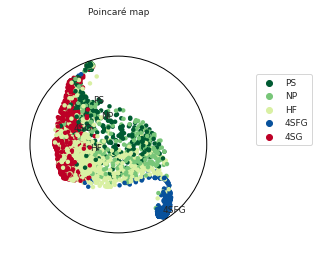

In [2]:
model_name = 'Moignard2015'
col_dict = None

fin = f"datasets/{model_name}"
fout = f"MoingardAnalysis/{model_name}"

data, true_labels, col_names = read_data(fin, normalize=False, n_pca=0)

idx_ery = find(col_names, ['HbbbH1', 'Gata1', 'Nfe2', 'Gfi1b', 'Ikaros', 'Myb'])
idx_endo = find(col_names, ['Erg', 'Sox7', 'Sox17', 'HoxB4', 'Cdh5'])

color_dict = {'PS': '#005a32',
              'NP': '#78c679',
              'HF': '#d9f0a3',
             '4SFG': '#08519c',
             '4SG': '#bd0026',
             'meso': '#636363'}

true_labels_order = ['PS', 'NP', 'HF', '4SFG', '4SG']

true_labels_ori = np.copy(true_labels)
knn = 10
n_pcs = 0

fsetting = f"Moignard2015_MFIsym{knn:d}_klSym_sigma=1.00_gamma=2.00_lr=0.31_lrm=1.00_pca={n_pcs:d}_epochs=10000_batchsize=491_connected"
poincare_coord = pd.read_csv(f"results/{fsetting}.csv", sep=',', header=None).values
model = PoincareMaps(poincare_coord)

model.plot('ori', labels=true_labels, file_name=fout + '_ori', 
           title_name='Poincaré map', coldict=color_dict, labels_order=true_labels_order, 
           zoom=None, bbox=(1.1, 0.8))

model.get_distances()

Hematopoetic genes


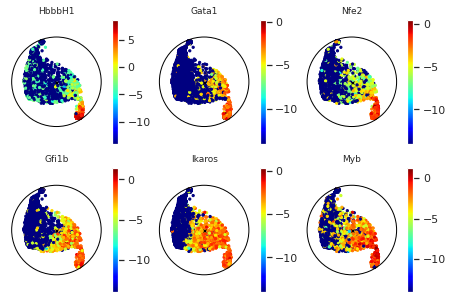

Endothelial genes


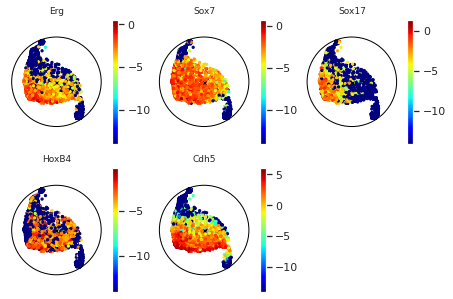

In [3]:
print('Hematopoetic genes')
model.plot_markers(data[:,idx_ery], col_names[idx_ery], 
                   file_name=fout + '_ery_markers', pm_type='ori', sc=2.5, fs=9)

print('Endothelial genes')
model.plot_markers(data[:,idx_endo], col_names[idx_endo], 
                   file_name=fout + '_endo_markers', pm_type='ori', sc=2.5, fs=9)


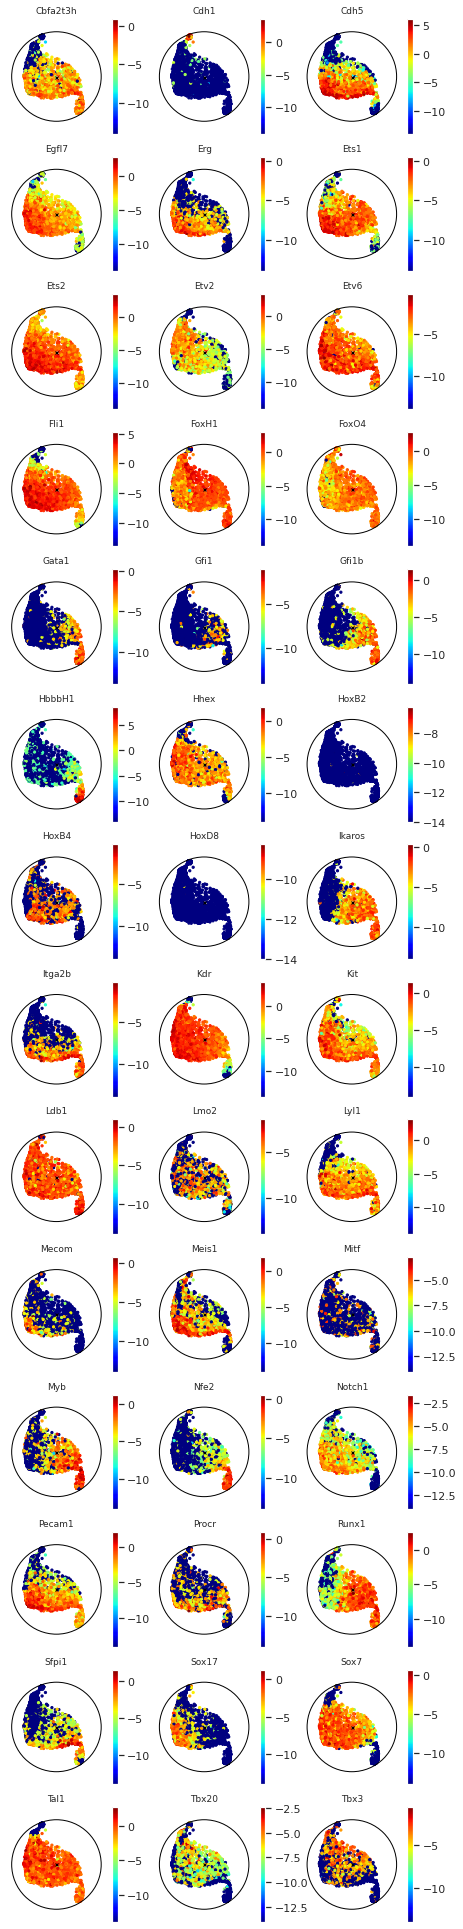

In [4]:
model.plot_markers(data, col_names, 
                   file_name=fout + '_markers_all', 
                   pm_type='ori', sc=2.5, fs=9)


... storing 'labels' as categorical


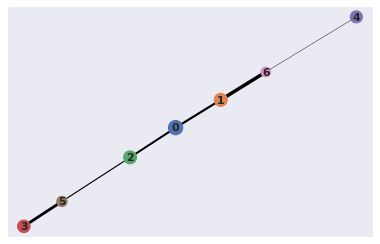

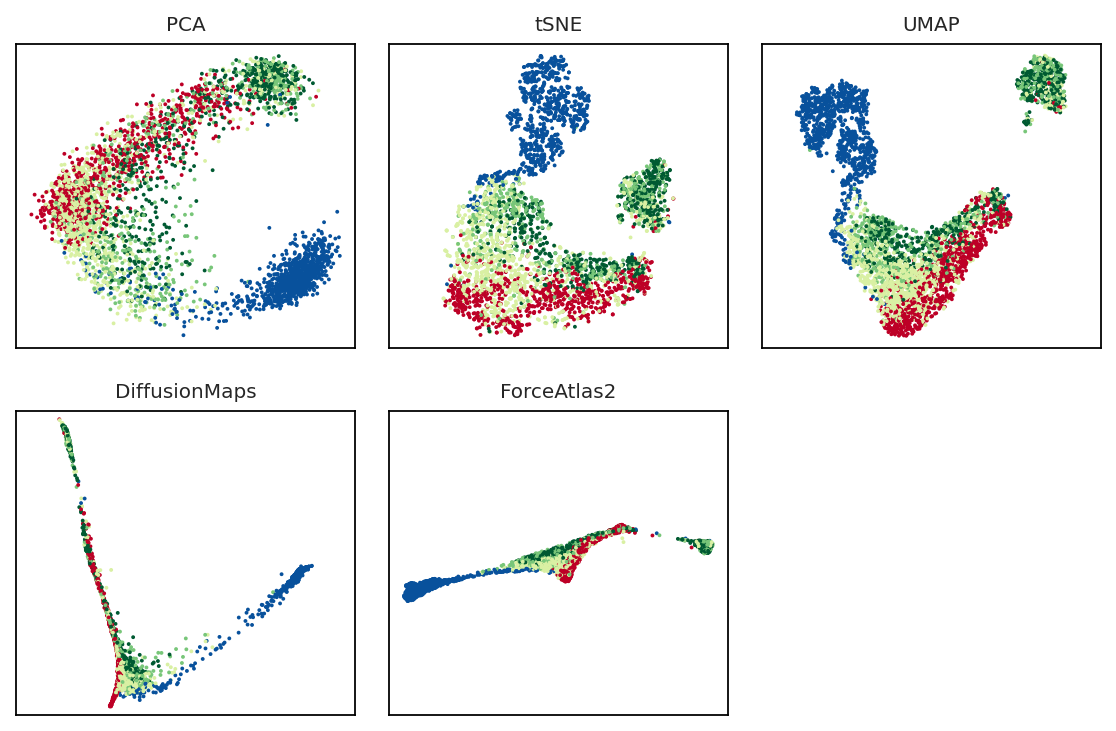

In [5]:
adata, iroot, louvain_labels = init_scanpy(data, col_names, 'PS', true_labels, fout, k=knn, n_pcs=n_pcs)
sc.pp.neighbors(adata, n_neighbors=knn, method='gauss', knn=False)
sc.tl.dpt(adata, n_branchings=1)
sc.tl.diffmap(adata)
plotBenchamrks(adata, true_labels, fout, coldict=color_dict)

Read results of the embeddings.

In the Haghverdi et al. they ommited the 'mesodermal' cluster. With Poincaré maps this cluster is very visible and we want to return the labels.

Longitud lista:['0' '1' '2' '3' '4' '5' '6'] [None] {'4SFG': 2298, '4SG': 3215, 'HF': 347, 'NP': 1516, 'PS': 1862}
Etiqueta :0


KeyError: '0'

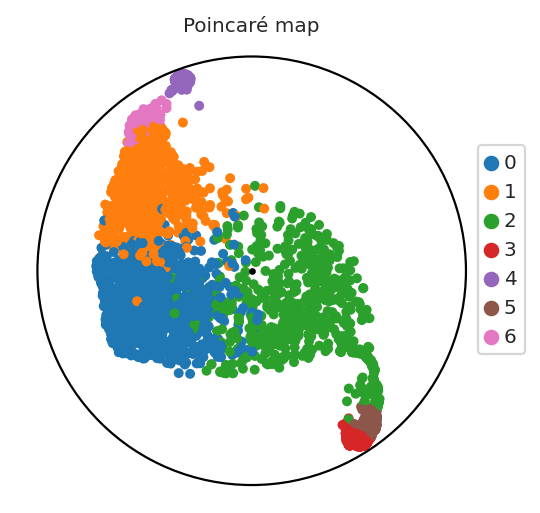

In [6]:
title_name = 'louvain'
model.plot('ori', labels=louvain_labels, file_name=fout + '_louvain', labels_name='louvain', 
           title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))

get_confusion_matrix(louvain_labels, true_labels_order, 
                     true_labels_ori, title=title_name, fname=fout + 'louvain_cm')


In [ ]:
np.random.seed(seed=2018)

title_name='clusters'
fname='{0}/{2}_{1}'.format(fin, model_name, title_name)

model.detect_cluster(n_clusters=5, clustering_name='spectral', k=30)
col_dict_clust = dict(zip(np.unique(model.clusters),
                          colors_palette[:len(np.unique(model.clusters))]))

model.plot('ori', labels=model.clusters, file_name=fout + '_clusters', labels_name='clusters', 
           title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))

get_confusion_matrix(model.clusters, true_labels_order, 
                     true_labels_ori, title=title_name, fname=fout + '_cm')

true_labels = np.copy(true_labels_ori)
meso_name = 2.0
true_labels[model.clusters == meso_name] = 'meso'

In [ ]:
fname='{0}/{1}'.format(fout, 'rotated_Haghverdi')
model.iroot = 532
model.rotate()
zoom_scale=1.2

color_dict['meso'] = '#636363'
title_name='rotated_Haghverdi'

model.plot('rot', labels=true_labels_ori, 
           d1=1.5*4.8, d2=1.5*4.6, fs=9, bbox=(0.82, 1.0),
           file_name=fname, coldict=color_dict)



According to Moignard et al.:<br/>
"Blood development initiates at gastrulation from multipotent Flk1+ (encoded by Flk1, also known as Kdr) meso- dermal cells, which initially have the potential to form blood, endothelium and smooth muscle cells".<br/>

"The first wave of primitive hematopoiesis originates from Flk1+ mesoderm, with all hematopoietic potential in the mouse contained within the Flk1+ population from E7.0 onwards. Although some blood progenitor cells lose Flk1 expression just before the onset of circulation, previous work using a LacZ reporter knocked into the Runx1 locus showed that hematopoietic potential remains confined to the Runx1+ fraction".<br/>

Therefore, we rename one of the clusters to the "mesodermal" cluster. However, it is not clear if this cluster is actually giving rise to the population as was proposed in the paper or this one will give rise to another population".

In [ ]:
def plot_dp_on_poincare(coordinates, distances, cell=0, fs=9, title_name='None', file_name=None, d1=3.5, d2=3.1):
    fig = plt.figure(figsize=(d1, d2))
    circle = plt.Circle((0, 0), radius=1, color='black', fc="None")    
    cm = plt.cm.get_cmap('rainbow')

    mycmap = distances
    
    plt.gca().add_patch(circle)
    plt.plot(0, 0, 'x', c=(0, 0, 0), ms=4)

    if title_name:
#         plt.title(title_name, fontsize=fs)
        plt.scatter(coordinates[:, 0], coordinates[:, 1], c=mycmap, s=10, cmap=cm)
        plt.plot(coordinates[cell, 0], coordinates[cell, 1], 'd', c='red')

        plt.plot(0, 0, 'x', c=(1, 1, 1), ms=4)    
        plt.axis('off')
        plt.axis('equal')        

        plt.axis('off')
        plt.axis('equal')
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=fs) 

        if file_name:
            plt.savefig(file_name + '.pdf', format='pdf')

        plt.show()
        plt.close(fig)

In [ ]:
model.iroot

In [ ]:
model.iroot = 532
model.rotate()

adata.uns['iroot'] = 532
sc.tl.dpt(adata, n_branchings=1)

model.plot('rot', labels=true_labels_ori, 
           d1=4.0, d2=3.7, fs=9, bbox=(1.35, 0.7), ms=3,
           file_name=fname + "rotated_hagh", coldict=color_dict)


plot_dp_on_poincare(model.coordinates_rotated, 
                    np.array(adata.obs['dpt_pseudotime']), cell=532,
                    title_name='dpt_pseudotime', file_name=fout+'_dpt_pseudotime_rotated', fs=fs)


plot_dp_on_poincare(model.coordinates_rotated, 
                    model.distances[model.iroot, :], cell=532,
                    title_name='dpt_pseudotime', file_name=fout+'_pmt_pseudotime_rotated', fs=fs)

In [ ]:
plot_dp_on_poincare(model.coordinates, 
                    np.array(adata.obs['dpt_pseudotime']), cell=532,
                    title_name='dpt_pseudotime', file_name=fout+'_dpt_pseudotime', fs=fs)

In [ ]:
title_name = 'haghverdi_ori'
model.plot_distances(cell=None, pm_type='ori', eps=10.0, file_name=fout + '_' + title_name,
                     title_name=None, idx_zoom=None, show=False, fs=fs)


In [ ]:
idx_4 = np.where(model.clusters == meso_name)[0]
idx_not4 = np.where(model.clusters != meso_name)[0]

idx_4_ps = idx_4[np.where(true_labels_ori[idx_4] == 'PS')[0]]
idx_not4_ps = idx_not4[np.where(true_labels_ori[idx_not4] == 'PS')[0]]

idx = find(col_names, ['Kdr', 'Runx1', 'Cdh1'])

med4 = np.reshape(np.mean(data[idx_4_ps], axis=0), [1, -1])
mednot4 = np.reshape(np.mean(data[idx_not4_ps], axis=0), [1, -1])


In [ ]:
model.clusters

In [ ]:
df = pd.DataFrame(np.concatenate((med4, mednot4)), 
                  columns=col_names, index=['meso', 'others'])

f, ax = plt.subplots(figsize=(20, 2))
sns.heatmap(df, annot=True, linewidths=.5, ax=ax, cmap='rainbow')
# plt.title('Median expression', fontsize=fs)
fname='{0}'.format(fout, 'meso_heatmap_all')
plt.savefig(fname + '.pdf', format='pdf')



In [ ]:
d = np.abs(med4-mednot4)
idx_sig = np.argsort(-d)[0]
idx_sig = idx_sig[np.where(d[:, idx_sig][0] > 0)[0]]

In [ ]:
df = pd.DataFrame(np.concatenate((med4[:, idx], mednot4[:, idx])), 
                  columns=col_names[idx], index=['meso', 'others'])

# Supplementary figure 1 D

In [ ]:
f, ax = plt.subplots(figsize=(4, 2))
sns.heatmap(df, annot=True, linewidths=.5, ax=ax, cmap='rainbow')
# plt.title('Median expression', fontsize=fs)
plt.savefig(fout + 'meso_heatmap.pdf', format='pdf')

In [ ]:
tips_n4 = pd.DataFrame(data[idx_not4_ps, :], columns=col_names)
tips_n4['stage'] = true_labels[idx_not4_ps]

tips = pd.DataFrame(data[idx_4_ps, :], columns=col_names)
tips['stage'] = true_labels[idx_4_ps]

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(3, 4), sharex=True)

for i, gene_name in enumerate(['Kdr', 'Runx1', 'Cdh1']):
    ax[i].hist(tips_n4[gene_name], color='#bdbdbd')
    ax[i].hist(tips[gene_name], color=col_dict_clust[meso_name])
#     plt.legend(['others', 'cluster2'])
    # plt.title('Runx1')
    ax[i].grid('off')
    ax[i].xaxis.set_tick_params(labelsize=fs)
    ax[i].yaxis.set_tick_params(labelsize=fs)
    ax[i].set_title(gene_name, fontsize=fs)
fname='{0}/{1}'.format(fin, 'meso_hist')
plt.tight_layout()
plt.savefig(fout + '_mesogenes.pdf', format='pdf')

"The first wave of primitive hematopoiesis originates from Flk1+ mesoderm, with all hematopoietic potential in the mouse contained within the Flk1+ population from E7.0 onwards. Although some blood progenitor cells lose Flk1 expression just before the onset of circulation, previous work using a LacZ reporter knocked into the Runx1 locus showed that hematopoietic potential remains confined to the Runx1+ fraction".

Therefore, we rename one of the clusters to the "mesodermal" cluster. However, it is not clear if this cluster is actually giving rise to the population as was proposed in the paper or this one will give rise to another population".

In [ ]:
model.plot('ori', labels=true_labels, file_name=fout + '_reannotated', labels_name='clusters', 
           title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8), coldict=color_dict)

In [ ]:
model.plot_distances_between_clusters(true_labels, pm_type='ori', eps=3.0, 
                                      file_name=fout + '_distbwclusters', fs=fs)


After the redefinening the labels we want to place 'PS' in the middle.

# Find the right root of the hierarchy

In [ ]:
# np.unique(true_labels)
head_idx = np.where(true_labels == 'PS')[0]
D = pairwise_distances(data[head_idx, :], metric='euclidean')
iroot_ps = head_idx[np.argmin(D.sum(axis=0))]
print('iroot_ps = ', iroot_ps)

In [ ]:
import random
head_idx = np.where(true_labels == 'PS')[0]

idx_leaf1 = random.choice(np.where(true_labels == '4SFG')[0])

idx_leaf2 = random.choice(np.where(true_labels == '4SG')[0])

idx1 = random.choice(np.where(model.distances[idx_leaf2, head_idx]/np.max(model.distances[idx_leaf2, head_idx]) < 0.4))

print(idx1)
# print(np.argsort(model.distances[idx_leaf1, head_idx]))
# print(np.argsort(model.distances[idx_leaf2, head_idx]))
# plt.scatter(model.distances[idx_leaf1, head_idx]/np.max(model.distances[idx_leaf1, head_idx]),                         
#             model.distances[idx_leaf2, head_idx]/np.max(model.distances[idx_leaf2, head_idx]))

# plt.scatter(model.distances[idx_leaf1, 2080]/np.max(model.distances[idx_leaf1, head_idx]), 
#             model.distances[idx_leaf2, 2080]/np.max(model.distances[idx_leaf2, head_idx]))

# print(idx_leaf)
iroot_ps = head_idx[idx1]

In [ ]:
fname='{0}_{1}'.format(fout, 'rotated_PS')
model.iroot = 2080
model.rotate()
zoom_scale=1.2

title_name='rotation'
# model.plot('rot', labels=true_labels, file_name=fname + '_' + title_name,
#            d1=10.5, d2=10.0, fs=9, bbox=(0.85, 1.0), ms=15,
#            title_name='rotation')


model.plot('rot', labels=true_labels_ori, 
           d1=4.0, d2=3.7, fs=9, bbox=(1.35, 0.7), ms=3,
           file_name=fname, coldict=color_dict)

adata.uns['iroot'] = model.iroot
sc.tl.dpt(adata, n_branchings=1)
plot_dp_on_poincare(model.coordinates_rotated, 
                    np.array(adata.obs['dpt_pseudotime']), cell=model.iroot,
                    title_name='dpt_pseudotime', file_name=fout+'_dpt_pseudotime_rotated_PS', fs=fs)


plot_dp_on_poincare(model.coordinates_rotated, 
                    model.distances[model.iroot, :], cell=model.iroot,
                    title_name='dpt_pseudotime', file_name=fout+'_pmt_pseudotime_rotated_PS', fs=fs)

# title_name='rotation'
# model.plot_distances(cell=None, pm_type='rot', eps=10.0, file_name=fname + '_' + title_name,
#                      title_name=None, idx_zoom=None, show=False, fs=fs)

# title_name='distances'
# model.plot_distances(cell=None, pm_type='rot', eps=10.0, file_name=fname + '_' + title_name,
#                      title_name=None, idx_zoom=None, show=False, fs=fs)


# title_name='rotation_clusters'

# model.plot_distances(cell=None, pm_type='rot', eps=10.0, file_name=fname + '_' + title_name,
#                      title_name=None, idx_zoom=None, show=False, fs=fs)



In [ ]:
model.plot('rot', labels=true_labels, 
           d1=4.5, d2=4.0, fs=9, bbox=(1.35, 0.7), ms=3,
           file_name=fname + 'forlin', coldict=color_dict)

model.plot('rot', labels=model.lineages, 
           d1=4.5, d2=4.0, fs=9, bbox=(1.35, 0.7), ms=3,
           file_name=fname + 'lin')


So here we can see that placing to the root to PS is coinciding with the physical time, but placing the root to the 'meso' (how was done in the paper) is orthogonal to the actual time.

In [ ]:
plot_dp_on_poincare(model.coordinates_rotated, 
                    np.array(adata.obs['dpt_pseudotime']), cell=model.iroot,
                    title_name='dpt_pseudotime', file_name=fout+'_dpt_pseudotime_rotated_my_myroot', fs=fs)

In [ ]:
np.random.seed(seed=2018)
title_name='lineages'

model.detect_lineages(n_lin=5, clustering_name='ward', k=30, rotated=True)
model.lineages[true_labels == 'meso'] = -1
model.lineages[model.lineages == 3] = -1
model.lineages[model.lineages == 4] = 3

model.plot('rot', labels=model.lineages, file_name=fout + '_lineages', 
            fs=9, title_name=title_name)

get_confusion_matrix(model.lineages, ['PS', 'NP', 'HF', '4SFG', '4SG', 'meso'], true_labels, title=title_name, 
                     fname=fout + '_lineages_cm')

In [ ]:
# , 'Itga2b', 'Pecam1', 'Fli1'])

In [ ]:
print('Hematopoetic genes')
model.plot_markers(data[:,idx_ery], col_names[idx_ery], 
                   file_name=fout + '_ery_markers', pm_type='rot', sc=2.5, fs=9)

print('Endothelial genes')
model.plot_markers(data[:,idx_endo], col_names[idx_endo], 
                   file_name=fout + '_endo_markers', pm_type='rot', sc=2.5, fs=9)


From the plot above we see, that some of the hematopoetic genes are on from the very beginning to form the blood cells. However, with endothelial branch the thinga are more complicated. Lineage one is showing low expression of endothelial genes. Possibly cells in lineage 1 don't even correspond to the endothelial branch.

In [ ]:
adata.uns['iroot'] = 532
sc.tl.dpt(adata, n_branchings=1)

true_labels_list = np.unique(true_labels)
sns.set(style="whitegrid")

title_name = 'Diffusion_pseudotime'
fig = plt.figure(figsize=(2.8, 2.))
tips = pd.DataFrame(np.array(adata.obs['dpt_pseudotime']), columns=['Diffusion pseudotime'])
tips['stages'] = true_labels
ax = sns.violinplot(x="stages", y='Diffusion pseudotime', 
                    order = ['PS', 'NP', 'HF', '4SFG', '4SG'], 
                    palette = color_dict, data=tips)
ax.grid('off')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.title('Diffusion pseudotime (old root)', fontsize=fs)
fig.tight_layout()

plt.savefig(fout + title_name + '_violin.pdf', format='pdf')


In [ ]:
true_labels_list = np.unique(true_labels)
sns.set(style="whitegrid")

title_name = 'Poincaré_pseudotime'
fig = plt.figure(figsize=(2.8, 2.))
tips = pd.DataFrame(model.distances[model.iroot], columns=['Poincaré pseudotime'])
tips['stages'] = true_labels
ax = sns.violinplot(x="stages", y='Poincaré pseudotime', 
                    order = ['PS', 'NP', 'HF', '4SFG', '4SG'], 
                    palette = color_dict, data=tips)
ax.grid('off')
plt.ylabel('')
plt.xlabel('')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.title('Poincaré pseudotime (new root)', fontsize=fs)
fig.tight_layout()

plt.savefig(fout + title_name + '_violin.pdf', format='pdf')


In [ ]:
model.iroot

In [ ]:
sns.set(style="whitegrid")

n1 = 1
n2 = 4
fs=9
pl_size=2
fig, axs = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n2*pl_size , n1*pl_size))
true_labels_list = np.unique(true_labels)

l=0
# for i in range(n1):
for j in range(n2):
    if l < len(np.unique(model.lineages))-1:
        idx_lin = np.where(model.lineages == l)[0]
        tips = pd.DataFrame(model.distances[model.iroot][idx_lin], columns=['pseudotime'])
        tips['stages'] = true_labels[idx_lin]
        ax = sns.violinplot(x="stages", y='pseudotime', 
                            order = ['PS', 'NP', 'HF', '4SFG', '4SG'], 
                            palette = color_dict,
                            data=tips, ax=axs[j])
#         axs[i, j] = ax
        axs[j].grid('off')        
        axs[j].set_title('Lineage '+str(l), fontsize=fs)
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')            
        axs[j].xaxis.set_tick_params(labelsize=fs)
        axs[j].yaxis.set_tick_params(labelsize=fs)
    else:
        axs[j].grid('off')
        axs[j].axis('off')
    l += 1

fig.tight_layout()
plt.savefig(fout + 'lineages' + '_violin.pdf', format='pdf')

# Analyse marker expressions for different lineages

In [ ]:
n1=2
n2=3


fig, axs = plt.subplots(n1, n2, sharex=True, sharey=False, figsize=(n2*pl_size + 2, n1*pl_size))

# Load an example dataset with long-form data
idx = np.random.permutation(len(data))
df = pd.DataFrame(data[idx, :], columns=col_names)
df['pseudotime'] = model.distances[model.iroot][idx]
df['lineages'] = model.lineages[idx]
coldict_lin = dict(zip(np.unique(model.lineages), colors_palette[:len(np.unique(model.lineages))]))

l=0
for i1 in range(n1):
    for i2 in range(n2):
        axs[i1, i2].grid('off')
        sns.scatterplot(x="pseudotime", y=col_names[idx_ery[l]], hue='lineages', 
                        palette=coldict_lin,
                        alpha=1.0, edgecolor="none",
                        data=df, s=3, ax=axs[i1, i2])
        axs[i1, i2].legend_.remove()
        l+=1
fig.tight_layout()
# plt.scatter(fmri['timepoint'], fmri[col_names[0]], s=5, cmap=cm)
# Plot the responses for different events and regions


# Mesodermal? Not endothelial?

In [ ]:
model.plot('rot', labels=model.lineages, file_name=fout + '_lineages_rot', labels_name='clusters', 
           title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))


In [ ]:
fname = '{0}/lineages_meso'.format(fin)
idx_cluster = np.where(model.lineages == 2 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], col_names[idx_ery], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_ery')
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], col_names[idx_endo], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_endo')

In [ ]:
fname = '{0}/lineages_meso'.format(fin)
idx_cluster = np.where(model.lineages == 0 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], col_names[idx_ery], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_ery')
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], col_names[idx_endo], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_endo')

model.plot_pseudotime(data, col_names, true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_all')

In [ ]:
fname = '{0}/lineages_meso'.format(fin)
idx_cluster = np.where(model.lineages == 0 )[0]
print('Erythroid markers')
model.plot_pseudotime(data, col_names, true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_all')

In [ ]:
fname = '{0}/lineages_meso'.format(fin)
idx_cluster = np.where(model.lineages == 1 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], col_names[idx_ery], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_ery')
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], col_names[idx_endo], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_endo')

## 4SG lineage

In [ ]:
fname = '{0}/lineages_4SG'.format(fin)
idx_cluster = np.where(model.lineages == 1 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], col_names[idx_ery], true_labels, 
                      idx=idx_cluster, fs=fs, file_name=fout + '_ery', colors_dict=color_dict)
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], col_names[idx_endo], 
                      true_labels, idx=idx_cluster, colors_dict=color_dict,
                      fs=fs, file_name=fout + '_endo')


In [ ]:
name = '{0}/lineages_4SG'.format(fin)
idx_cluster = np.where(model.lineages == 2 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], col_names[idx_ery], true_labels, 
                      colors_dict=color_dict, idx=idx_cluster, fs=fs, file_name=fout + '_ery')
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], 
                      col_names[idx_endo], true_labels,
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_endo')

# Undecided

In [ ]:
name = '{0}/lineages_4SG'.format(fin)
idx_cluster = np.where(model.lineages == 2 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], col_names[idx_ery], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_ery')
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], col_names[idx_endo], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fout + '_endo')


# Blood cells

In [ ]:
fname = '{0}/lineages_4SFG'.format(fin)
idx_cluster = np.where(model.lineages == 0 )[0]
print('Erythroid markers')
model.plot_pseudotime(data[:, idx_ery], 
                      col_names[idx_ery], true_labels, 
                      colors_dict=color_dict,
                      idx=idx_cluster, fs=fs, file_name=fname + '_ery')
print('Endothelial markers')
model.plot_pseudotime(data[:, idx_endo], col_names[idx_endo], true_labels, idx=idx_cluster, fs=fs, file_name=fname + '_endo')

In [ ]:
fname = '{0}/distbwlineages'.format(fin)
model.plot_distances_between_clusters(model.lineages, 
                                      pm_type='rotation', eps=3.0, 
                                      file_name=fname, fs=fs)

# PS between different lineages

Blood development initiates at gastrulation from multipotent Flk1+ (encoded by Flk1, also known as Kdr) mesodermal cells, which initially have the potential to form blood, endothelium and smooth muscle cells.<br/>

Endothelial branch: 4SG (Expression: Flk1 and Runx1, Pecam1, Cdh5).<br/>
Erythroid branch: 4SFG (Expression: Gata1)

# Reproduce Hagheverdi: https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170501_moignard15/moignard15.ipynb

In [ ]:
import scanpy.api as sc
adata = sc.AnnData(data)
adata.var_names = col_names

# adata_h.uns['iroot'] = 2080
sc.pp.neighbors(adata, n_neighbors=5, method='gauss', knn=False)

In [ ]:
adata.uns['iroot'] = 532
sc.tl.dpt(adata, n_branchings=1)

In [ ]:
sc.pl.diffmap(adata, color=['dpt_pseudotime'])


In [ ]:
adata.obs['dpt_groups'].cat.categories = [
    'undecided/endothelial', 'erythrocytes', 'trunk', 'endothelial']

In [ ]:
sc.pl.diffmap(adata, color='dpt_groups')


In [ ]:
model.plot('rot', labels=model.clusters, 
           d1=d1, d2=d1, bbox=(0.9, 0.9),
           file_name=None, show=True)
print('lineages')
model.plot('rot', labels=model.lineages, 
           d1=d1, d2=d1, bbox=(0.9, 0.9),
           file_name=None, show=True)

In [ ]:
adata.obs['poincare_clusters'] = [str(i) for i in np.array(model.clusters)]
ax = sc.pl.heatmap(adata, col_names, groupby='poincare_clusters')

In [ ]:
print(fname)
model.plot('rot', labels=np.array(adata.obs['dpt_groups']), 
           d1=d1, d2=d1, bbox=(0.9, 0.9),
           file_name=fout+'_dpt_groups', show=True)

In [ ]:
d = model.distances[model.iroot, :]
idx_sort = np.argsort(d)
lin = model.lineages[idx_sort]

i1 = np.where(lin == 1)[0]
i2 = np.where(lin == 5)[0]

ii = np.concatenate([i1, i2])

idx = idx_sort[ii]

X = np.transpose(data[idx, :])
print(true_labels[idx])


In [ ]:
fig = plt.figure(figsize=(1.5*4, 2*4))
im = plt.imshow(np.array(X, dtype=np.float_), aspect='auto',
               interpolation='nearest', cmap='rainbow')
plt.colorbar(shrink=0.5)
plt.yticks(range(X.shape[0]), col_names)
# plt.xlim([0, data.shape[1]-1])
# plt.ylim([0, data.shape[0]-1])

In [ ]:
sc.pl.dpt_timeseries(adata, color_map='rainbow')

In [ ]:
sc.tl.rank_genes_groups(adata, 'poincare_clusters', groups='all', n_genes=5,
compute_distribution=False, only_positive=True,
copy=False)

In [ ]:
sc.pl.rank_genes_groups(adata)

# Pseudotime comparison

In [ ]:
sns.set(style="whitegrid")

title_name = 'dpt_pseudotime'
fig = plt.figure(figsize=(4, 2.4))
tips = pd.DataFrame(adata.obs['dpt_pseudotime'], columns=['dpt_pseudotime'])
tips['stages'] = true_labels_ori
ax = sns.violinplot(x="stages", y='dpt_pseudotime', 
                    palette = dict(zip(true_labels_ori, colors_palette[:len(true_labels_ori)])),
                    order = ['PS', 'NP', 'HF', '4SFG', '4SG'], data=tips)
ax.grid('off')
plt.ylabel('')
plt.xlabel('')
plt.title('Diffusion pseudotime')
plt.savefig(fname + title_name + '_violin.pdf', format='pdf')


In [ ]:
np.unique(model.lineages)

In [ ]:
sns.set(style="whitegrid")

n1 = 2
n2 = 3 
pl_size=2.0
fig, axs = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(n2*pl_size + 2, n1*pl_size))
true_labels_list = np.unique(true_labels)

l=0
for i in range(n1):
    for j in range(n2):
        if l < len(np.unique(model.lineages))-1:
            idx_lin = np.where(model.lineages == l)[0]
            tips = pd.DataFrame(model.distances[iroot_ps][idx_lin], columns=['pseudotime'])
            tips['stages'] = true_labels[idx_lin]
            ax = sns.violinplot(x="stages", y='pseudotime', 
                                order = ['meso', 'PS', 'NP', 'HF', '4SFG', '4SG'], 
                                palette = color_dict,
                                data=tips, ax=axs[i, j])
    #         axs[i, j] = ax
            axs[i, j].grid('off')        
            axs[i, j].set_title('Lineage '+str(l), fontsize=fs)
            axs[i, j].set_ylabel('')
            axs[i, j].set_xlabel('')            
            axs[i, j].xaxis.set_tick_params(labelsize=fs)
            axs[i, j].yaxis.set_tick_params(labelsize=fs)
        else:
            axs[i, j].grid('off')
            axs[i, j].axis('off')
        l += 1
        
plt.savefig(fout + 'lineages' + '_violin.pdf', format='pdf')

# Figure 2

In [ ]:
model.plot('rot', labels=model.lineages, 
           d1=d1, d2=d1, bbox=(0.9, 0.9),
           file_name=None, show=True)

In [ ]:
lin_and_time_names = []
for i in range(len(true_labels)):
    if true_labels[i] == 'meso':
        lin_and_time_names.append('meso')
    else:
        lin_and_time_names.append(str(model.lineages[i]) + '_' + true_labels[i])

In [ ]:
np.unique(model.lineages)

In [ ]:
lindict = dict(zip(np.unique(lin_and_time_names), colors_palette[:len(np.unique(lin_and_time_names))]))
stage_order = ['PS', 'NP', 'HF', '4SFG', '4SG']

for c in coldict.keys():
    red = Color(coldict[c])
    colors = list(red.range_to(Color("#f0f0f0"), 12))
    for i in range(5):
        k = str(c) + '_' + stage_order[i]
        lindict[k] = str(colors[i])
        
lindict['meso'] = colors_palette[0]
# lindict

lin_and_time_names = np.array(lin_and_time_names)    
model.plot('rot', labels=lin_and_time_names, 
           coldict=lindict,
           d1=6.9, d2=7.2, bbox=(1.2, 0.9),
           file_name=None, show=True)

In [ ]:
idx_imp = np.concatenate([idx_endo, idx_ery])

a = np.arange(len(col_names))
mask = np.array([(i in idx_imp) for i in range(len(col_names))])

idx_col = np.concatenate([a[~mask], idx_imp])
print(idx_col)
col_names

In [ ]:
d = model.distances[model.iroot, :]
idx_sort = np.argsort(d)
lin = model.lineages[idx_sort]

idx=np.empty([0])
highlightsX=[]
for l in [-1, 2, 4, 1, 3, 0]:
    ii = np.where(lin == l)[0]
    if len(ii):
        idx = np.concatenate([idx, idx_sort[ii]])
        highlightsX.append(len(idx)-1)
idx = [int(i) for i in idx]

# idx_imp = np.concatenate([idx_endo, idx_ery])
# idx_col = idx_endo
# idx_col = idx_ery

X = np.transpose(data[idx, :][:, idx_col])
col_names_hm = col_names[idx_col]

# X = np.transpose(data[idx, :])

time = np.array([0 if l=='PS' else 3 for l in true_labels_ori[idx]])
time[np.where(true_labels_ori[idx] == 'HF')[0]] = 1
time[np.where(true_labels_ori[idx] == 'NP')[0]] = 2
time = np.reshape(time, [1, -1])
# X = np.append(X, time, axis=0)

In [ ]:
fname

In [ ]:
fig = plt.figure(figsize=(1.5*4, 2*4))
im = plt.imshow(np.array(X, dtype=np.float_), aspect='auto',
               interpolation='nearest', cmap='rainbow')
for ih, h in enumerate(highlightsX):
    plt.plot([h, h], [0, X.shape[0]], '-', color='white')
cbar = plt.colorbar(shrink=0.3)
cbar.ax.tick_params(labelsize=fs) 
plt.yticks(range(X.shape[0]), col_names_hm, fontsize=fs)
plt.xticks([])
plt.xlim([0, X.shape[1]-1])
plt.ylim([0, X.shape[0]-1])
plt.savefig(fout + '_gene_expression.pdf', format='pdf')

In [ ]:
fig = plt.figure(figsize=(1.5*4, 2*4))
im = plt.imshow(np.array(X, dtype=np.float_), aspect='auto',
               interpolation='nearest', cmap='rainbow')
for ih, h in enumerate(highlightsX):
    plt.plot([h, h], [0, X.shape[0]], '-', color='white')
plt.colorbar(shrink=0.5)
plt.yticks(range(X.shape[0]), col_names)
plt.xticks([])
plt.xlim([0, X.shape[1]-1])
plt.ylim([0, X.shape[0]-1])
plt.savefig(fname + '_gene_expression_main.pdf', format='pdf')

In [ ]:
fig = plt.figure(figsize=(16, 0.5))
im = plt.imshow(np.array(time, dtype=np.float_), aspect='auto',
               interpolation='nearest', cmap='rainbow')
for ih, h in enumerate(highlightsX):
    plt.plot([h, h], [-1, time.shape[0]+1], '--', color='black')
plt.yticks(range(time.shape[0]), ['stages'])
plt.xlim([0, time.shape[1]-1])
plt.ylim([0, time.shape[0]-1])


In [ ]:
true_labels